## TD N°2 explicabilité du dataset Boston Housing

1) Charger le dataset bostong_housing
   1) Disponible dans le folder 04_interpretable_ml/td/data/
   
2) Nettoyer votre jeu de données pour créer une régression linéaire et un random forest
   1) Tester d'ajouter des features log, quadratique, ...

3)Créer un modèle baseline linéaire et random forest

4) Interpréter le modèle linéaire

5) Tuner votre random forest

6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

6) Réaliser une explicabilité par individu
   1) En utilisant la méthode ICE (PDP individuelle)
   2) LIME (Model local pour expliquer une prédiction)
   3) SHAP watterfall plot (Contribution marginale de chaque variable dans la prédiction)

7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

## Contexte du Dataset

Le Boston Housing Dataset est un ensemble de données couramment utilisé en apprentissage automatique et en statistique pour étudier les relations entre diverses caractéristiques socio-économiques et immobilières dans la ville de Boston.  
Il contient des informations sur des propriétés résidentielles et leur environnement, et est souvent utilisé pour prédire la valeur des maisons, un problème classique de régression.

**Variable dispo**: 
- CRIM : taux de criminalité par habitant par ville
- ZN : proportion de terrains résidentiels zonés pour des lots de plus de 25 000 pieds carrés
- INDUS : proportion de terrains commerciaux non commerciaux par ville
- CHAS : variable binaire indiquant la proximité de la rivière Charles (= 1 si la zone délimitée par la ville touche la rivière ; 0 sinon)
- NOX : concentration des oxydes d'azote (en parties par 10 millions)
- RM : nombre moyen de pièces par logement
- AGE : proportion des unités occupées par leur propriétaire et construites avant 1940
- DIS : distances pondérées vers cinq centres d'emploi de Boston
- RAD : indice d'accessibilité aux autoroutes radiales
- TAX : taux d'imposition foncière par valeur totale pour chaque tranche de 10 000 dollars
- PTRATIO : ratio élèves-enseignants par ville
- LSTAT : pourcentage de la population de statut socio-économique inférieur
- MEDV : valeur médiane des maisons occupées par leur propriétaire (en milliers de dollars) - **variable cible**

In [1]:
#Librairies
import requests
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

from lime.lime_tabular import LimeTabularExplainer
import shap

import warnings
warnings.filterwarnings('ignore')

### 1) Charger le dataset bostong_housing

In [2]:
#Télécharge directement depuis Github
url = "https://raw.githubusercontent.com/Roulitoo/cours_iae/master/04_INTERPRETABLE_ML/td/data/boston_housing.csv" 
download = requests.get(url).content

df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=';')

In [3]:
df

,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,9.67,22.4
502,502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,9.08,20.6
503,503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,5.64,23.9
504,504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,6.48,22.0


Notre dataset contient 506 lignes (observations) et 14 colonnes (variables).

##### Suppression de la variable Unnamed : 0 qui correspond à un ID.

In [4]:
df = df.drop(columns=['Unnamed: 0'])

Nous passons donc à 13 variables.

### 2)Nettoyer votre jeu de données pour créer une régression linéaire et un random forest

Penser à :

- Vérifier comment encoder vos variables qualitatives pour la modélisation 
- Analyser les distributions
- Analyser les outliers 
- Analyser les corrélations

>Tester d'ajouter des features log, quadratique, ...

#### Valeurs manquantes

In [5]:
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
MEDV       0
dtype: int64

Ici, il n'y a pas de valeurs manquantes.

#### Statistiques descriptives

In [6]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


#### Type de données

In [7]:
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
LSTAT      float64
MEDV       float64
dtype: object

Nous observons que les variables **CHAS**, qui indique la proximité de la rivière Charles sous forme binaire (0 ou 1), ainsi que **RAD**, représentant l'indice d'accessibilité aux autoroutes radiales, sont exprimées sous forme d'entiers. Les valeurs de **RAD** varient de 1 à 24, sans décimales. Cependant, ces deux variables sont en réalité catégorielles, car elles représentent des groupes distincts ou des catégories (proximité de la rivière ou indices d'accès aux routes). Par conséquent, il serait pertinent de les transformer en variables catégorielles afin de mieux refléter leur nature non continue.

In [8]:
df['CHAS'] = df['CHAS'].astype('category')
df['RAD'] = df['RAD'].astype('category')

In [9]:
df.dtypes

CRIM        float64
ZN          float64
INDUS       float64
CHAS       category
NOX         float64
RM          float64
AGE         float64
DIS         float64
RAD        category
TAX         float64
PTRATIO     float64
LSTAT       float64
MEDV        float64
dtype: object

Les variables sont correctement typées.

#### Standardisation

In [10]:
#Identifier les variables à exclure
excluded_columns = ['CHAS', 'RAD'] 

#Séparer les variables continues (tout sauf 'CHAS' et 'RAD')
df_continuous = df.drop(columns=excluded_columns)

#Séparer les variables binaires et catégorielles
df_excluded = df[excluded_columns]

#Initialiser le scaler
scaler = StandardScaler()

#Standardiser uniquement les variables continues
df_continuous_standardized = pd.DataFrame(scaler.fit_transform(df_continuous), columns=df_continuous.columns)

#Rejoindre les variables standardisées avec les variables binaires et catégorielles non modifiées
df = pd.concat([df_continuous_standardized, df_excluded], axis=1)

print(df.describe())

               CRIM            ZN         INDUS           NOX            RM  \
count  5.060000e+02  5.060000e+02  5.060000e+02  5.060000e+02  5.060000e+02   
mean  -1.123388e-16  7.898820e-17  2.106352e-16 -1.965929e-16 -1.088282e-16   
std    1.000990e+00  1.000990e+00  1.000990e+00  1.000990e+00  1.000990e+00   
min   -4.197819e-01 -4.877224e-01 -1.557842e+00 -1.465882e+00 -3.880249e+00   
25%   -4.109696e-01 -4.877224e-01 -8.676906e-01 -9.130288e-01 -5.686303e-01   
50%   -3.906665e-01 -4.877224e-01 -2.110985e-01 -1.442174e-01 -1.084655e-01   
75%    7.396560e-03  4.877224e-02  1.015999e+00  5.986790e-01  4.827678e-01   
max    9.933931e+00  3.804234e+00  2.422565e+00  2.732346e+00  3.555044e+00   

                AGE           DIS         TAX       PTRATIO         LSTAT  \
count  5.060000e+02  5.060000e+02  506.000000  5.060000e+02  5.060000e+02   
mean  -1.474446e-16 -8.425408e-17    0.000000 -4.212704e-16 -3.089316e-16   
std    1.000990e+00  1.000990e+00    1.000990  1.000990e+

#### Outliers

In [11]:
def detect_outliers(df):
    outliers = {}
    
    # Itérer sur les colonnes continues
    for column in df.columns:
        # Vérifier si la colonne est continue (exclure les variables catégorielles)
        if df[column].dtype in ['int64', 'float64']:
            # Calcul des quartiles
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            
            # Calcul des limites pour les outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Détection des outliers
            outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers

# Détecter les outliers dans le dataset
outliers = detect_outliers(df)

# Afficher les outliers détectés pour chaque variable
for column, values in outliers.items():
    print(f"Outliers pour {column}:")
    print(values)
    print("\n")

Outliers pour CRIM:
         CRIM        ZN     INDUS       NOX        RM       AGE       DIS  \
367  1.153105 -0.487722  1.015999  0.659147 -3.450002  1.117494 -1.085954   
371  0.653875 -0.487722  1.015999  0.659147 -0.097781  1.117494 -1.248292   
373  0.872168 -0.487722  1.015999  0.978765 -1.964083  1.117494 -1.245868   
374  1.732178 -0.487722  1.015999  0.978765 -3.058221  1.117494 -1.263551   
375  1.861457 -0.487722  1.015999  1.004680  1.465070  1.042817 -1.178318   
..        ...       ...       ...       ...       ...       ...       ...   
468  1.392077 -0.487722  1.015999  0.218592 -0.510932  0.086238 -0.421483   
469  1.101074 -0.487722  1.015999  0.218592 -0.814384 -0.422278 -0.461746   
477  1.327804 -0.487722  1.015999  0.512296 -1.397069  1.021481 -0.805438   
478  0.770330 -0.487722  1.015999  0.512296 -0.141945  1.000145 -0.772257   
479  1.247542 -0.487722  1.015999  0.512296 -0.079260  0.690768 -0.876506   

          TAX   PTRATIO     LSTAT      MEDV CHAS RAD  


À titre d'exemple, les variables CRIM et ZN présentent respectivement 66 et 68 valeurs aberrantes, soulignant ainsi des écarts significatifs dans leurs distributions.

#### Graphiques

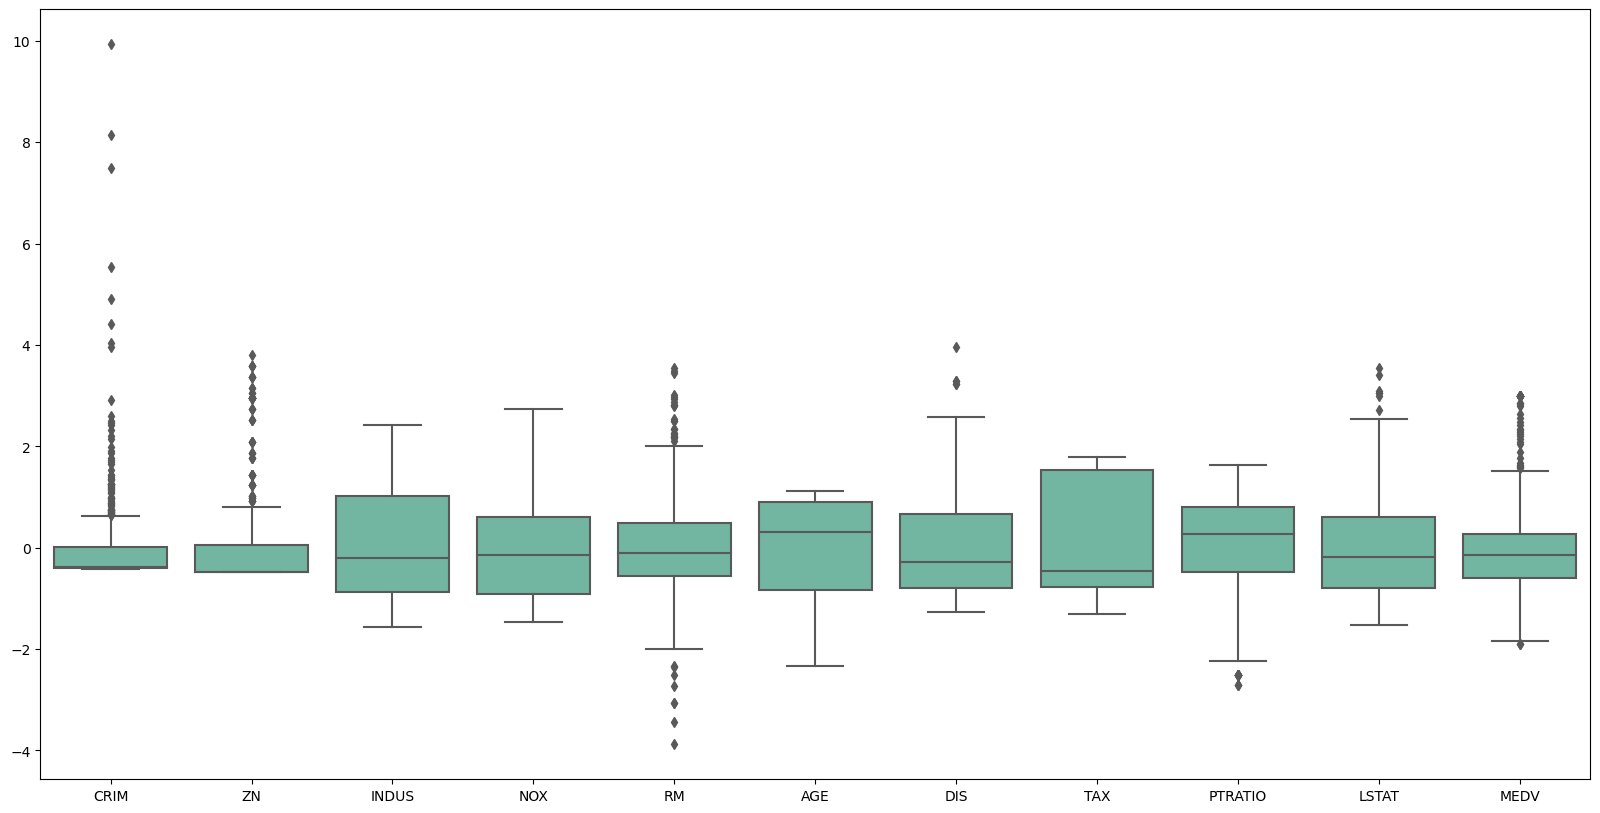

In [12]:
# Exclure les variables 'RAD' et 'CHAS'
df_without_RAD_CHAS = df.drop(columns=['RAD', 'CHAS'])

# Créer un boxplot avec une couleur verte spécifique
plt.figure(figsize=(20, 10))

# Créer un boxplot sans 'RAD' et 'CHAS'
sns.boxplot(data=df_without_RAD_CHAS, color='#66c2a5')  

# Afficher le graphique
plt.show()

Sur ces boxplots des variables quantitatives, nous remarquons que certaines variables, telles que **CRIM** (taux de criminalité par habitant par ville), **ZN** (proportion de terrains résidentiels zonés pour des lots de plus de 25 000 pieds carrés), **RM** (nombre moyen de pièces par logement), **LSTAT** (pourcentage de la population de statut socio-économique inférieur) et **MEDV** (valeur médiane des maisons occupées par leur propriétaire en milliers de dollars, qui correspond à notre variable cible), présentent de nombreux outliers.

<Figure size 1500x1000 with 0 Axes>

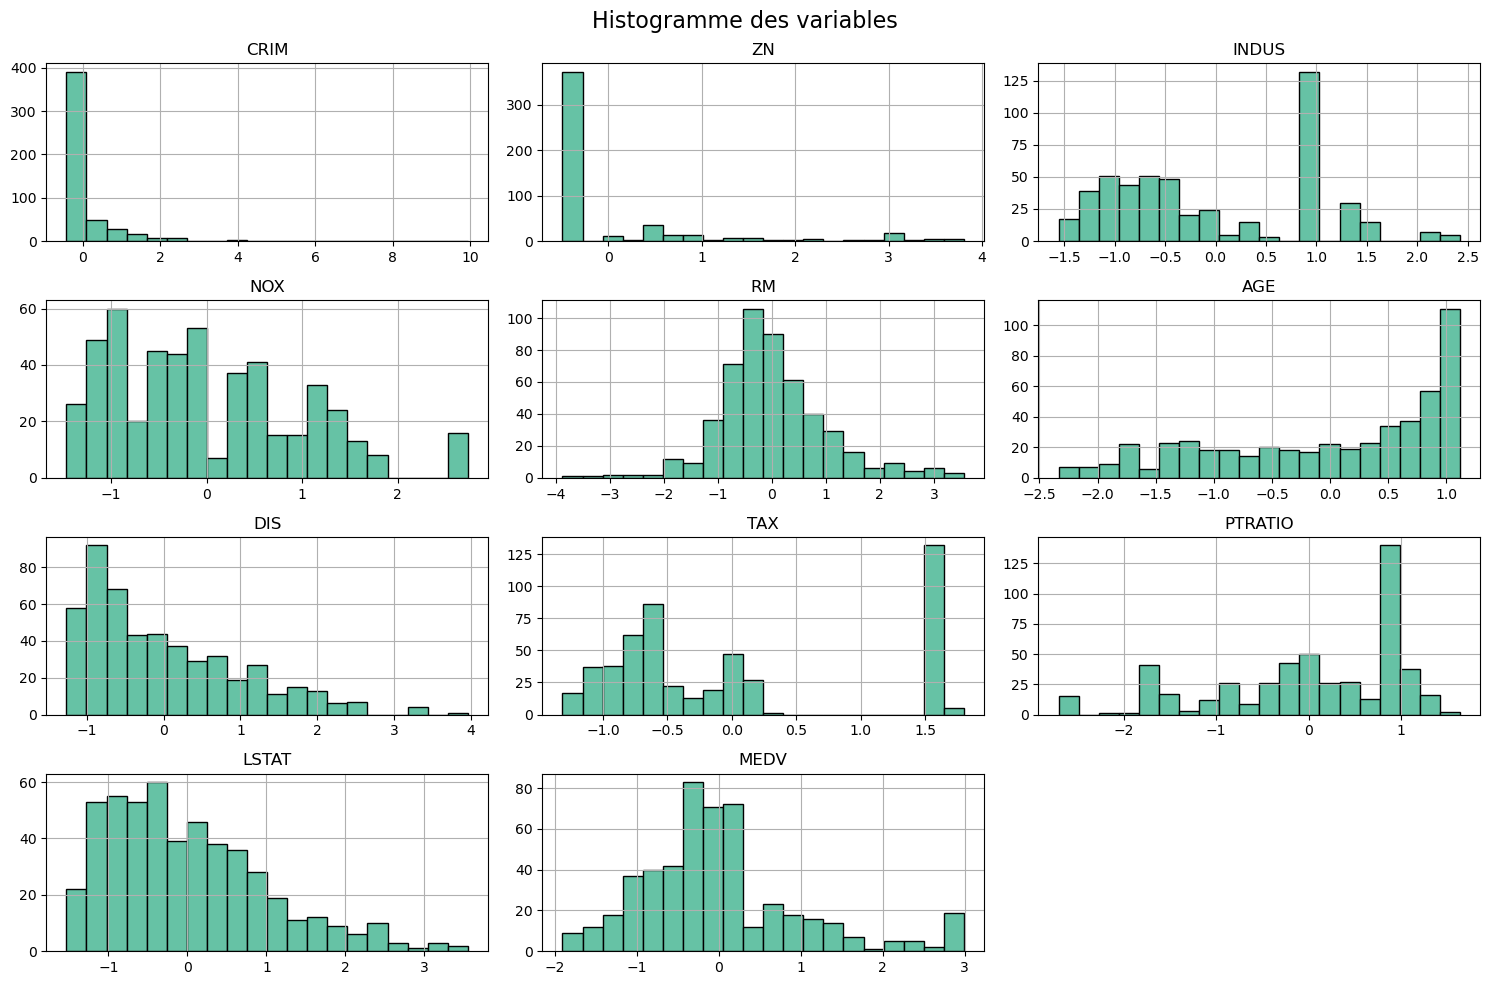

In [13]:
#Exclure les variables 'RAD' et 'CHAS'
df_without_RAD_CHAS = df.drop(columns=['RAD', 'CHAS'])

plt.figure(figsize=(15, 10))
sns.set_palette("Set2")

df_without_RAD_CHAS.hist(bins=20, edgecolor='black', figsize=(15, 10))

plt.suptitle('Histogramme des variables', fontsize=16)
plt.tight_layout()
plt.show()

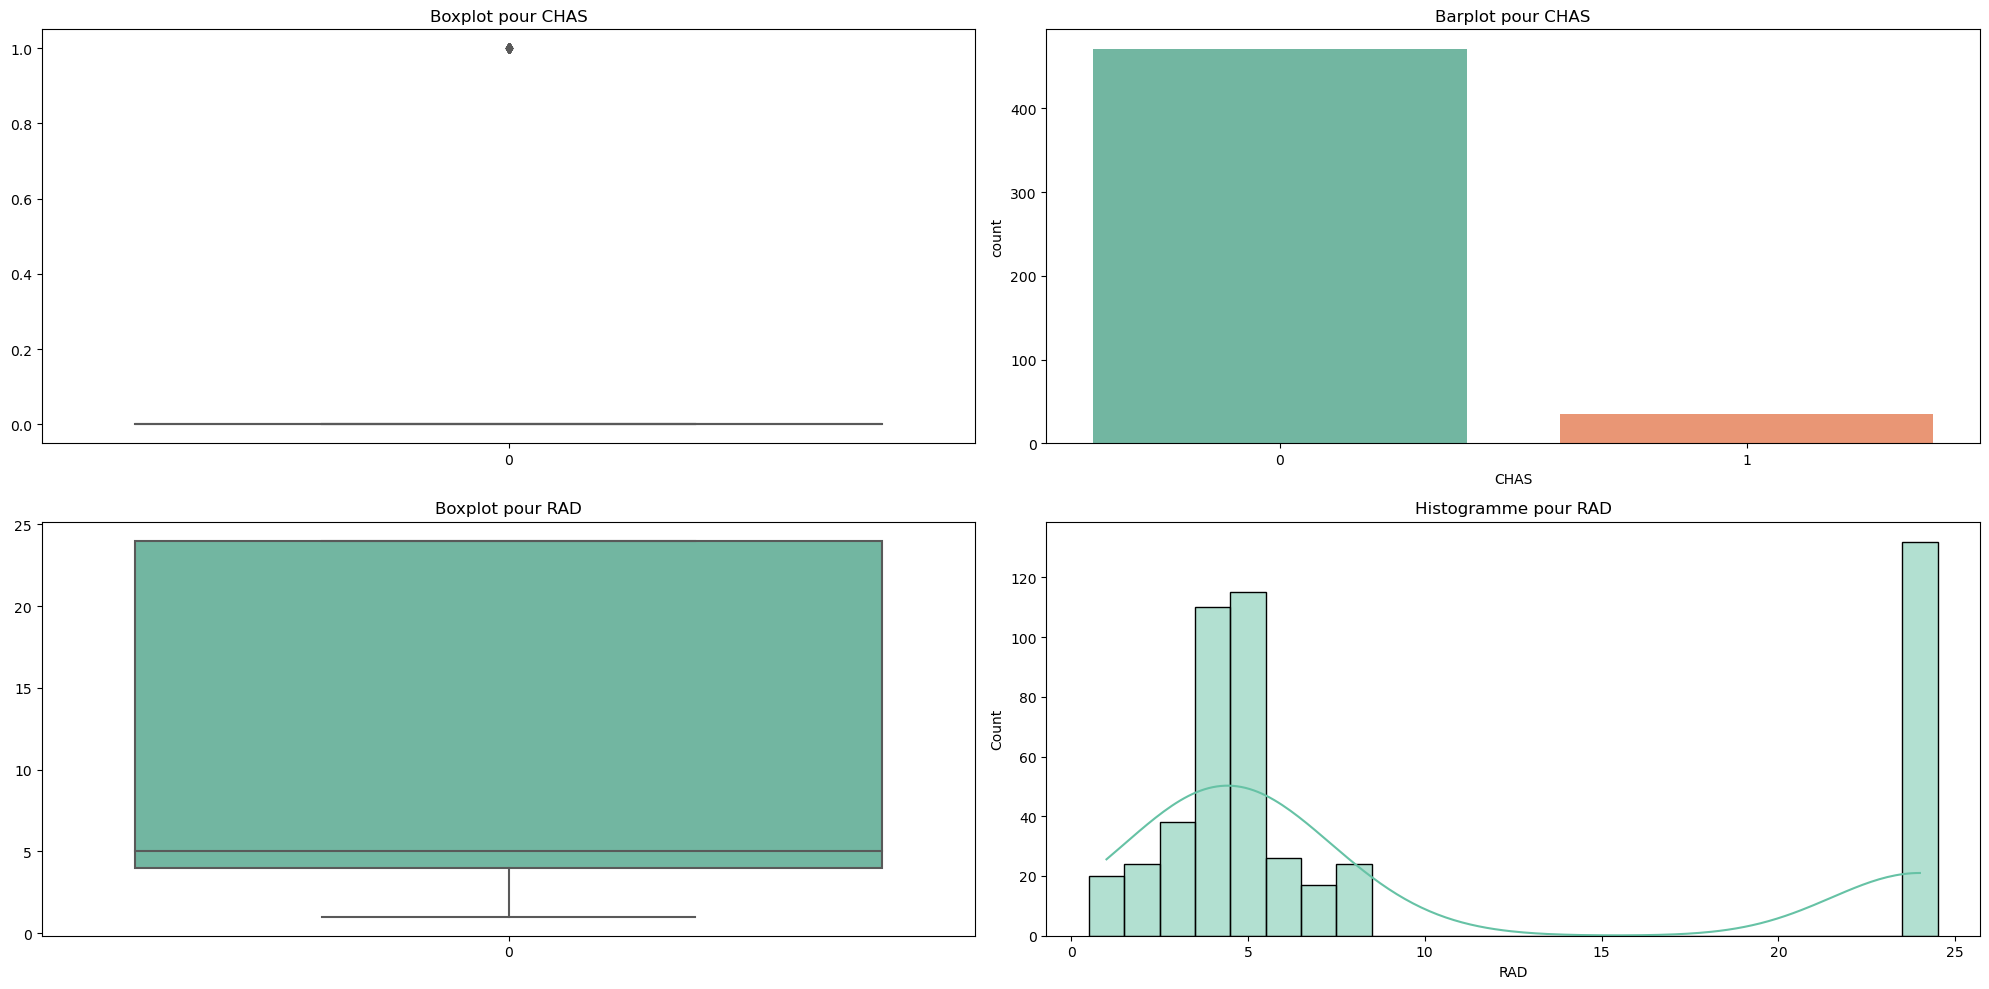

In [14]:
sns.set_palette("Set2")

# Créer une figure avec 2 lignes et 2 colonnes de sous-graphiques
plt.figure(figsize=(20, 10))

# Première ligne, première colonne : Boxplot pour 'CHAS'
plt.subplot(2, 2, 1)
sns.boxplot(data=df['CHAS'])
plt.title('Boxplot pour CHAS')

# Première ligne, deuxième colonne : Barplot pour 'CHAS'
plt.subplot(2, 2, 2)
sns.countplot(x=df['CHAS'])
plt.title('Barplot pour CHAS')

# Deuxième ligne, première colonne : Boxplot pour 'RAD'
plt.subplot(2, 2, 3)
sns.boxplot(data=df['RAD'])
plt.title('Boxplot pour RAD')

# Deuxième ligne, deuxième colonne : Histogramme pour 'RAD'
plt.subplot(2, 2, 4)
sns.histplot(df['RAD'], kde=True, bins=10)
plt.title('Histogramme pour RAD')

plt.tight_layout()
plt.show()

Nous remarquons sur les graphiques de **CHAS** qu'il y a une majorité de valeurs égales à 0 par rapport aux valeurs égales à 1, ce qui indique que la plupart des zones délimitées par la ville ne sont pas proches de la rivière. Nous allons maintenant vérifier cela.

In [15]:
count = df['CHAS'].value_counts()
print(count)

0    471
1     35
Name: CHAS, dtype: int64


Effectivement, les valeurs égales à 1 sont très rares dans notre jeu de données.

Pour la variable **RAD**, nous observons que les indices sont majoritairement concentrés entre 1 et 8, avec une fréquence particulièrement élevée pour les valeurs 4 et 5. En revanche, quelques observations se situent à 24, créant ainsi un écart notable entre les indices 8 et 24.

#### Corrélation

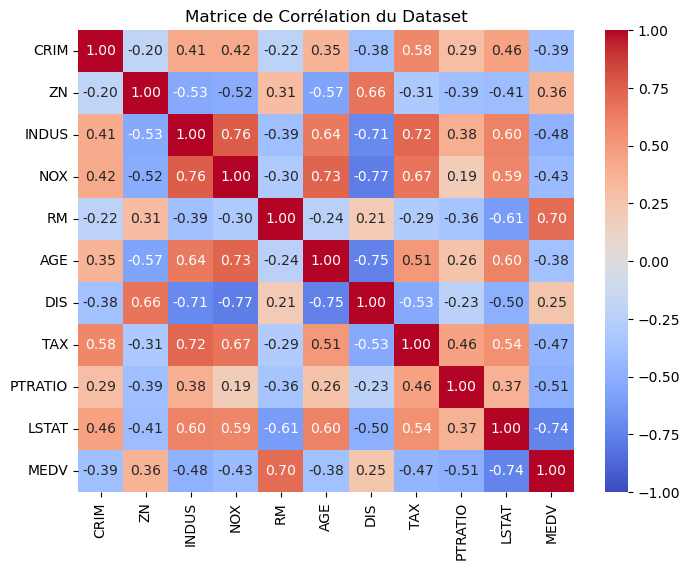

In [16]:
correlation_matrix = df.corr()

correlation_matrix

# Visualiser la matrice de corrélation avec un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation du Dataset')
plt.show()

Les variables les plus fortement corrélées dans notre analyse sont **NOX** (concentration des oxydes d'azote) et **DIS** (distances vers les centres d'emploi), avec une corrélation négative marquée (0.77). Une autre corrélation négative notable est observée entre **AGE** (proportion des unités occupées par leur propriétaire et construites avant 1940) et **DIS** (0.75). De plus, nous constatons également une corrélation négative entre **MEDV** (valeur médiane des maisons) et **LSTAT** (pourcentage de la population à statut socio-économique inférieur).

En ce qui concerne les corrélations positives, la plus forte est entre **NOX** et **INDUS** (proportion de terrains industriels), suivie de celle entre **NOX** et **AGE** (0.73).

#### Encoder les variables pour faire les modèles

In [17]:
label_encoder = LabelEncoder()

# Appliquer LabelEncoder à la variable RAD
df['RAD'] = label_encoder.fit_transform(df['RAD'])

# Afficher un aperçu du DataFrame après encodage
print(df.head())

       CRIM        ZN     INDUS       NOX        RM       AGE       DIS  \
0 -0.419782  0.284830 -1.287909 -0.144217  0.413672 -0.120013  0.140214   
1 -0.417339 -0.487722 -0.593381 -0.740262  0.194274  0.367166  0.557160   
2 -0.417342 -0.487722 -0.593381 -0.740262  1.282714 -0.265812  0.557160   
3 -0.416750 -0.487722 -1.306878 -0.835284  1.016303 -0.809889  1.077737   
4 -0.412482 -0.487722 -1.306878 -0.835284  1.228577 -0.511180  1.077737   

        TAX   PTRATIO     LSTAT      MEDV CHAS  RAD  
0 -0.666608 -1.459000 -1.075562  0.159686    0    0  
1 -0.987329 -0.303094 -0.492439 -0.101524    0    1  
2 -0.987329 -0.303094 -1.208727  1.324247    0    1  
3 -1.106115  0.113032 -1.361517  1.182758    0    2  
4 -1.106115  0.113032 -1.026501  1.487503    0    2  


#### Mettre la variable cible en dernière position

In [18]:
cols = [col for col in df.columns if col != 'MEDV']  #Créer une liste de colonnes sans 'MEDV'
df = df[cols + ['MEDV']]  #Réorganiser les colonnes en ajoutant 'MEDV' à la fin

### 3) Créer 2 modèles baseline, linéaire et random forest

#### Diviser les données

In [19]:
X = df.drop(columns=['MEDV'])
y = df['MEDV']  #Variable cible

#Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Afficher les dimensions des ensembles
print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de y_test: {y_test.shape}")

Dimensions de X_train: (404, 12)
Dimensions de X_test: (102, 12)
Dimensions de y_train: (404,)
Dimensions de y_test: (102,)


#### Linéaire

In [20]:
linear_model = LinearRegression()

#Entraîner le modèle sur les données d'entraînement
linear_model.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_linear = linear_model.predict(X_test)

#Calculer les performances du modèle
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Régression Linéaire")
print(f"Mean Squared Error (MSE): {mse_linear}")
print(f"R-squared (R2): {r2_linear}")

Régression Linéaire
Mean Squared Error (MSE): 0.2781257129034744
R-squared (R2): 0.679830383390996


#### Random Forest

In [21]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=77)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R2): {r2_rf}")

Random Forest
Mean Squared Error (MSE): 0.0991647498262197
R-squared (R2): 0.8858446434112783


La comparaison entre la **régression linéaire** et le modèle **Random Forest** montre des différences significatives en termes de performance. Le **Mean Squared Error (MSE)** pour la régression linéaire est de 0.2781, ce qui indique que les prédictions du modèle sont relativement éloignées des valeurs réelles, avec une erreur moyenne plus importante. En revanche, le modèle **Random Forest** présente un MSE bien inférieur de 0.0992, ce qui signifie que ses prédictions sont plus précises et plus proches des valeurs attendues, avec une erreur moyenne réduite.

En ce qui concerne le **R²**, un autre indicateur clé de la performance du modèle, la régression linéaire explique 67,98% de la variance des données, ce qui est raisonnable, mais loin d’être optimal. En revanche, le modèle Random Forest montre une amélioration notable avec un R² de 88,58%, ce qui signifie qu'il capture une plus grande proportion de la variance des données, offrant ainsi un meilleur ajustement. 

Ces résultats suggèrent que le modèle Random Forest est plus performant que la régression linéaire, avec une capacité supérieure à expliquer les variations des données et à effectuer des prédictions plus précises.

### 4) Interpréter le modèle linéaire
Utiliser les méthodes intrinsèques du modèle pour l'interprétation

In [22]:
#Afficher les coefficients du modèle linéaire
print("Coefficients du modèle linéaire:")
for feature, coef in zip(X.columns, linear_model.coef_):
    print(f"{feature}: {coef}")

#Afficher l'ordonnée à l'origine (intercept) = constante
print(f"Intercept (ordonnée à l'origine): {linear_model.intercept_}")

#Afficher les p-values des coefficients
import statsmodels.api as sm
X_with_intercept = sm.add_constant(X_train)  #Ajouter une constante (intercept) à X
model = sm.OLS(y_train, X_with_intercept).fit()  #Créer un modèle MCO
print(model.summary()) 

Coefficients du modèle linéaire:
CRIM: -0.1001586132631195
ZN: 0.08700481755880399
INDUS: 0.01086647685440955
NOX: -0.22141557435005646
RM: 0.3332439197792561
AGE: -0.019527162536394728
DIS: -0.3425730206911895
TAX: -0.1084635460462051
PTRATIO: -0.188686296938363
LSTAT: -0.41060478763262154
CHAS: 0.34020621843369314
RAD: 0.04654084546281595
Intercept (ordonnée à l'origine): -0.24591599099646208
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     91.56
Date:                Mon, 10 Feb 2025   Prob (F-statistic):          1.51e-105
Time:                        16:00:31   Log-Likelihood:                -308.83
No. Observations:                 404   AIC:                             643.7
Df Residuals:                     391   BIC:     

Le modèle de régression linéaire montre un bon ajustement avec un R-squared ajusté de 0.729, ce qui signifie qu'environ 72,9 % de la variance de la valeur médiane des maisons (MEDV) est expliquée par les variables indépendantes dans le modèle. Cela indique que le modèle est relativement performant dans l'explication des variations des prix des maisons.

##### Variables ayant un effet **positif** sur la valeur des maisons :
Les variables **ZN** (proportion de terrain résidentiel), **RM** (nombre de pièces), **CHAS** (proximité d'un cours d'eau) et **RAD** (accessibilité aux autoroutes) ont un effet positif sur la valeur des maisons. Une plus grande proportion de terrain résidentiel (**ZN**) et un nombre de pièces plus élevé (**RM**) augmentent significativement la valeur des maisons. De plus, la proximité d'un cours d'eau (**CHAS**) semble également augmenter la valeur des maisons, tout comme une meilleure accessibilité aux autoroutes (**RAD**). Ces résultats suggèrent que les quartiers avec plus d'espace résidentiel, un plus grand nombre de pièces et une proximité d'infrastructures importantes tendent à offrir des maisons de plus grande valeur.

##### Variables ayant un effet **négatif** sur la valeur des maisons :
Les variables **NOX** (pollution de l'air), **DIS** (proximité des centres d'emploi), **PTRATIO** (ratio élèves/professeurs) et **LSTAT** (proportion de la population à faible statut socio-économique) ont un effet négatif sur la valeur des maisons. Une augmentation de la pollution de l'air (**NOX**) et une plus grande distance aux centres d'emploi (**DIS**) réduisent significativement la valeur des maisons. De même, un plus grand ratio élèves/professeurs dans les écoles locales (**PTRATIO**) et une proportion plus élevée de la population à faible statut socio-économique (**LSTAT**) sont associés à une baisse de la valeur des maisons. Ces résultats indiquent que des environnements moins favorables en termes de pollution, d'éducation et de statut socio-économique tendent à entraîner une dépréciation de la valeur des propriétés.

### 5) Tuner votre random forest

In [23]:
rf = RandomForestRegressor(random_state=77)

#Définir la grille des hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

#Configurer la recherche par grille
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

#Appliquer la recherche par grille pour trouver les meilleurs paramètres
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres : ", grid_search.best_params_)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Meilleurs paramètres :  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [24]:
#Utiliser les meilleurs paramètres trouvés
best_rf = RandomForestRegressor(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=77
)

#Entraîner le modèle avec les meilleurs paramètres sur les données d'entraînement
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 0.11371081720464563
R2 Score: 0.8690996658718025


##### Contribution des variables

    Feature  Importance
4        RM    0.295110
9     LSTAT    0.263650
3       NOX    0.076668
2     INDUS    0.072205
0      CRIM    0.071926
6       DIS    0.062567
8   PTRATIO    0.060080
5       AGE    0.031746
7       TAX    0.031280
11      RAD    0.013711


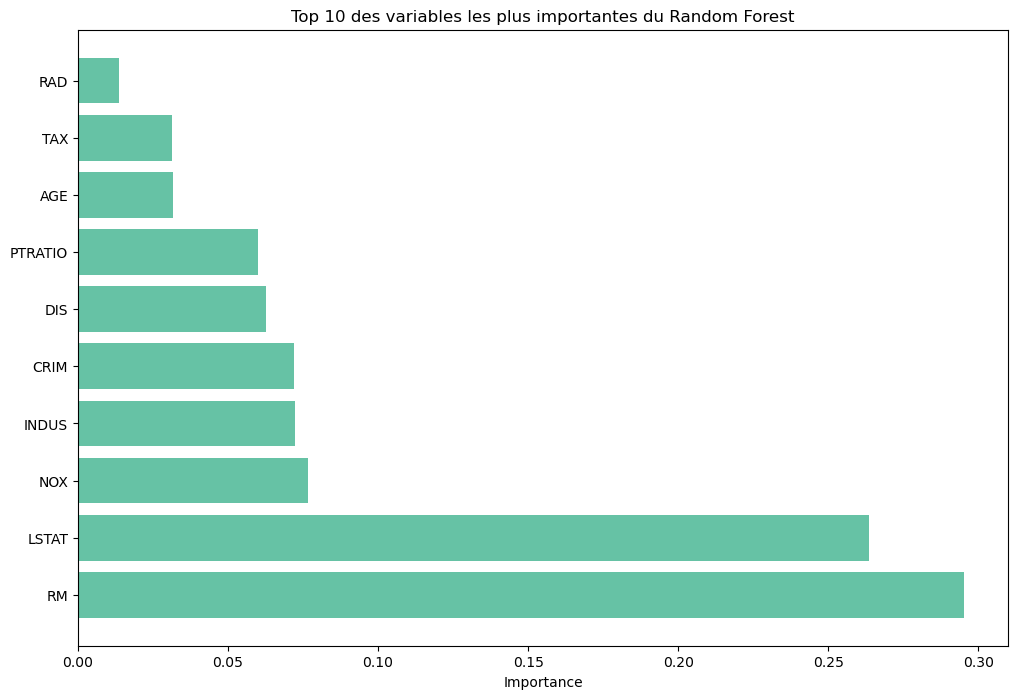

In [25]:
#Récupérer l'importance des caractéristiques
importances = best_rf.feature_importances_

#Créer un DataFrame avec les noms des features et leur importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

#Trier par ordre d'importance décroissante
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_10_features = feature_importance_df.head(10)
print(top_10_features)

plt.figure(figsize=(12, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 des variables les plus importantes du Random Forest')
plt.show()

Les variables les plus importantes dans le modèle sont **RM** (nombre moyen de pièces par logement) et **LSTAT** (pourcentage de la population de statut socio-économique inférieur), avec des importances respectives de **0.2951** et **0.2637**. Ces deux caractéristiques ont une forte influence sur la prédiction de la valeur des maisons, suggérant que le nombre de pièces et le statut socio-économique jouent un rôle crucial dans la détermination des prix.

D'autres variables comme **NOX** (concentration des oxydes d'azote), **INDUS** (proportion de terrains industriels), et **CRIM** (taux de criminalité) ont des importances modérées, tandis que des variables telles que **TAX** (taux d'imposition foncière) et **RAD** (indice d'accessibilité aux autoroutes) ont un impact relativement faible. Cela indique que certains facteurs environnementaux et socio-économiques ont un impact plus marqué sur la valeur des maisons que d'autres.

### 6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

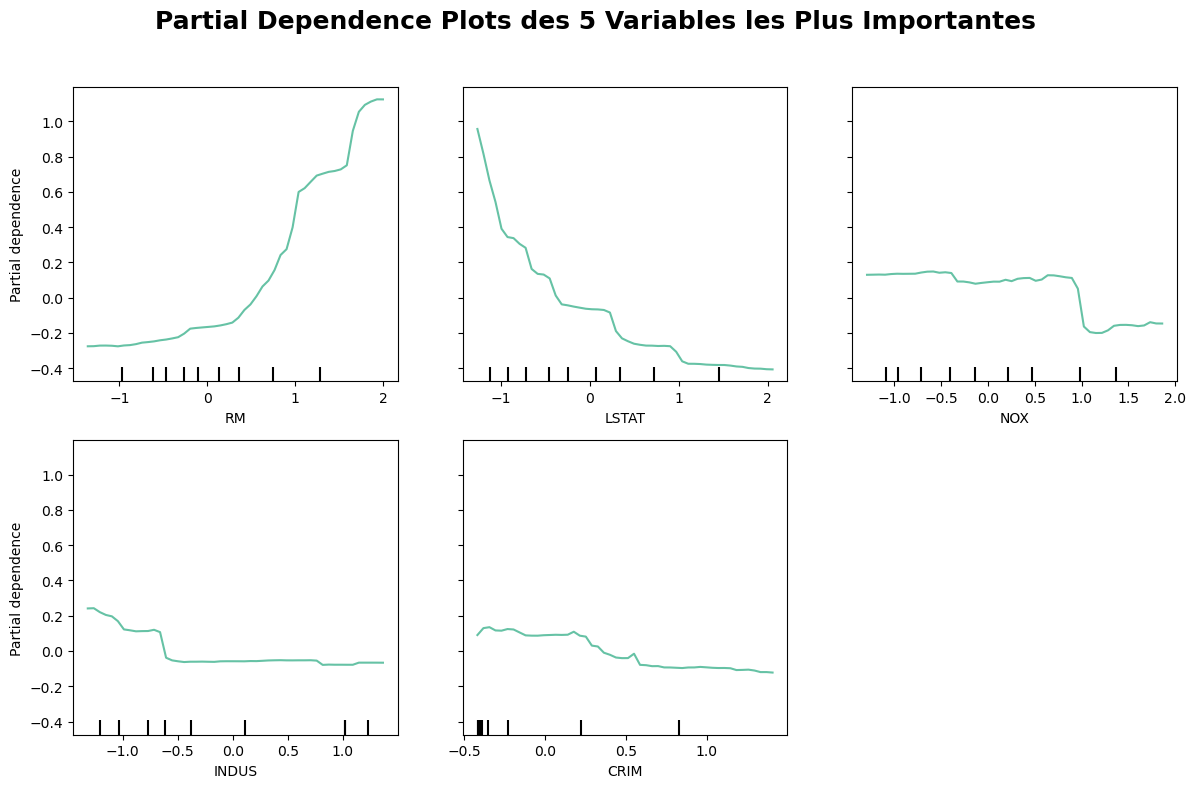

In [26]:
#Sélectionner les 5 features les plus importantes
top_features = feature_importance_df.head(5)['Feature'].tolist()

#Tracer les PDP pour les 5 features les plus importantes
fig, ax = plt.subplots(figsize=(12, 8))

display = PartialDependenceDisplay.from_estimator(
    best_rf,                        
    X_train,                        
    features=top_features,         
    grid_resolution=50,            
    ax=ax
)

fig.suptitle("Partial Dependence Plots des 5 Variables les Plus Importantes", fontsize=18, weight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuster l'espacement pour éviter les chevauchements
plt.show()

Ce graphique représente les *Partial Dependence Plots* (PDP) des cinq variables les plus importantes dans notre modèle de prédiction. Ces courbes illustrent l’effet marginal de chaque variable sur la prédiction du modèle, en maintenant les autres constantes. On observe que **le nombre moyen de pièces par logement (RM)** a un effet fortement positif : plus il y a de pièces, plus la valeur prédite augmente, suggérant que cette variable est un facteur clé. À l’inverse, **le pourcentage de la population à faible statut socio-économique (LSTAT)** a un effet négatif marqué, ce qui signifie que les quartiers avec une population plus modeste sont associés à des valeurs plus faibles de la variable cible.  

D’autres variables comme **la pollution de l’air (NOX), la proportion de terrains industriels (INDUS) et le taux de criminalité (CRIM)** ont des effets plus modérés. NOX semble légèrement négatif à partir d’un certain seuil, indiquant que la pollution peut avoir un impact défavorable. INDUS et CRIM, quant à eux, présentent des effets relativement plats, ce qui suggère qu’ils influencent moins directement la prédiction du modèle. Globalement, RM et LSTAT apparaissent comme les variables les plus déterminantes dans l’explication de la variable cible.

    Feature  Importance  Importance_std
9     LSTAT    0.357590        0.067675
4        RM    0.240045        0.035438
3       NOX    0.060340        0.011244
6       DIS    0.055407        0.003330
0      CRIM    0.035524        0.006137
8   PTRATIO    0.030001        0.007659
7       TAX    0.021272        0.005160
2     INDUS    0.020328        0.005157
5       AGE    0.014980        0.006147
11      RAD    0.012341        0.002875
1        ZN    0.000534        0.000619
10     CHAS   -0.002318        0.007393


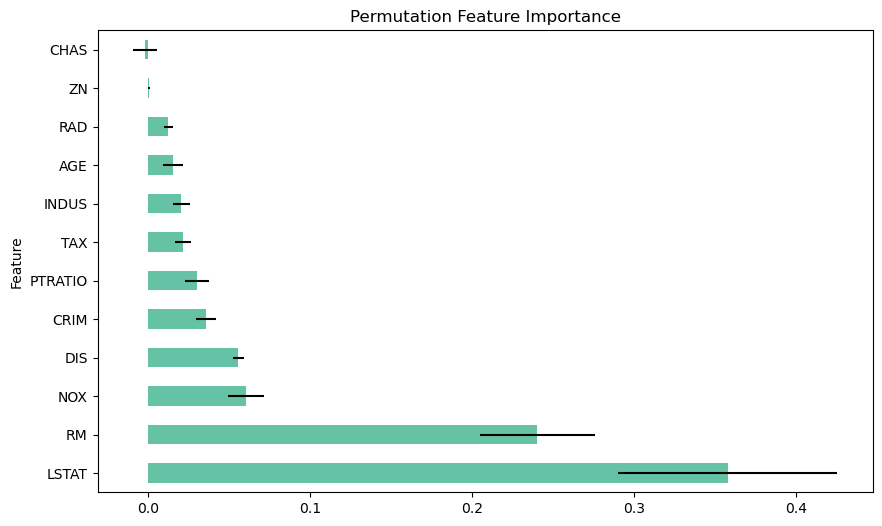

In [27]:
#Calculer l'importance des caractéristiques par permutation
result = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=77)

#Afficher l'importance des caractéristiques
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean,
    'Importance_std': result.importances_std
})

#Trier les features par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

importance_df.plot(kind='barh', x='Feature', y='Importance', xerr='Importance_std', legend=False, figsize=(10, 6))
plt.title('Permutation Feature Importance')
plt.show()

Ici on remarque l'importance relative des variables dans notre modèle de prédiction, montrant que **LSTAT (pourcentage de population à faible statut socio-économique) et RM (nombre moyen de pièces par logement)** sont les facteurs les plus influents. LSTAT a la plus grande importance (**0.3576**), ce qui suggère que les quartiers avec une population plus modeste sont fortement corrélés à la variable cible. De même, RM, avec une importance de **0.2400**, confirme que le nombre de pièces est un indicateur clé, généralement lié à des logements plus grands et de meilleure qualité.  

D’autres variables comme **NOX (pollution), DIS (distance aux centres d’emplois) et CRIM (taux de criminalité)** ont une influence modérée, tandis que **ZN (proportion de terrains résidentiels) et CHAS (proximité de la rivière Charles)** semblent négligeables. L’impact quasi nul, voire négatif, de CHAS indique qu’elle n’apporte pas d’information pertinente au modèle. Ces résultats suggèrent que la qualité socio-économique et structurelle des logements joue un rôle central, tandis que certains facteurs géographiques ou réglementaires sont moins déterminants dans la prédiction.

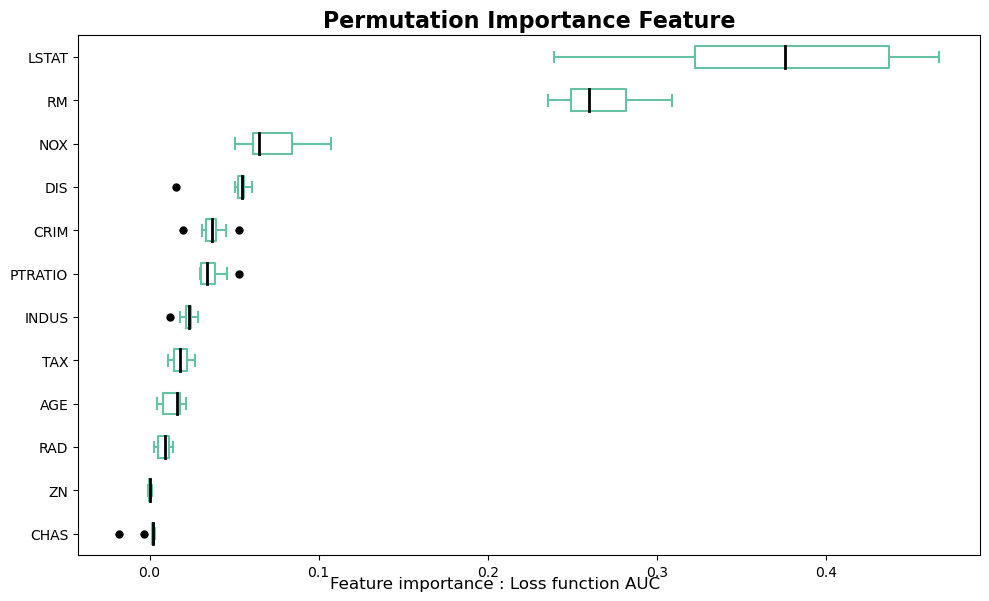

In [28]:
#Calculer l'importance des caractéristiques par permutation
resultat = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42)

#Trier les features par importance (en ordre croissant)
sortie = resultat.importances_mean.argsort()

#Personnaliser uniquement le contour du boxplot
boxprops = dict(color="#66c2a5", linewidth=1.5)
whiskerprops = dict(color="#66c2a5", linewidth=1.5)
capprops = dict(color="#66c2a5", linewidth=1.5)

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

ax1.boxplot(
    resultat.importances[sortie].T,
    vert=False,
    labels=X_train.columns[sortie],
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=dict(color="black", linewidth=2),  #Médiane en noir
    flierprops=dict(marker="o", markerfacecolor="black", markersize=5, linestyle="none"),  #Points aberrants en noir
)

plt.title("Permutation Importance Feature", fontsize=16, weight="bold", color="black")
fig.text(
    0.5, 
    0.01, 
    "Feature importance : Loss function AUC", 
    ha="center", 
    fontsize=12, 
    color="black"
)
fig.tight_layout()

plt.show()

Parmi les variables, **LSTAT** (pourcentage de population défavorisée) et **RM** (nombre moyen de pièces par logement) se distinguent comme étant les plus importantes, suivies de **NOX** (concentration en oxydes d'azote). Ces variables impactent significativement les prédictions du modèle.

En revanche, les variables comme **CHAS** (proximité d’un cours d’eau) et **ZN** (proportion de terrains résidentiels) apparaissent comme ayant une importance négligeable dans ce cadre. 

Ces résultats offrent une perspective claire sur les facteurs clés du modèle, facilitant ainsi l’interprétation et l’analyse des prédictions. Cela permet aussi de prioriser les variables à conserver ou à analyser plus en détail dans des étapes futures.

### 7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

##### ICE

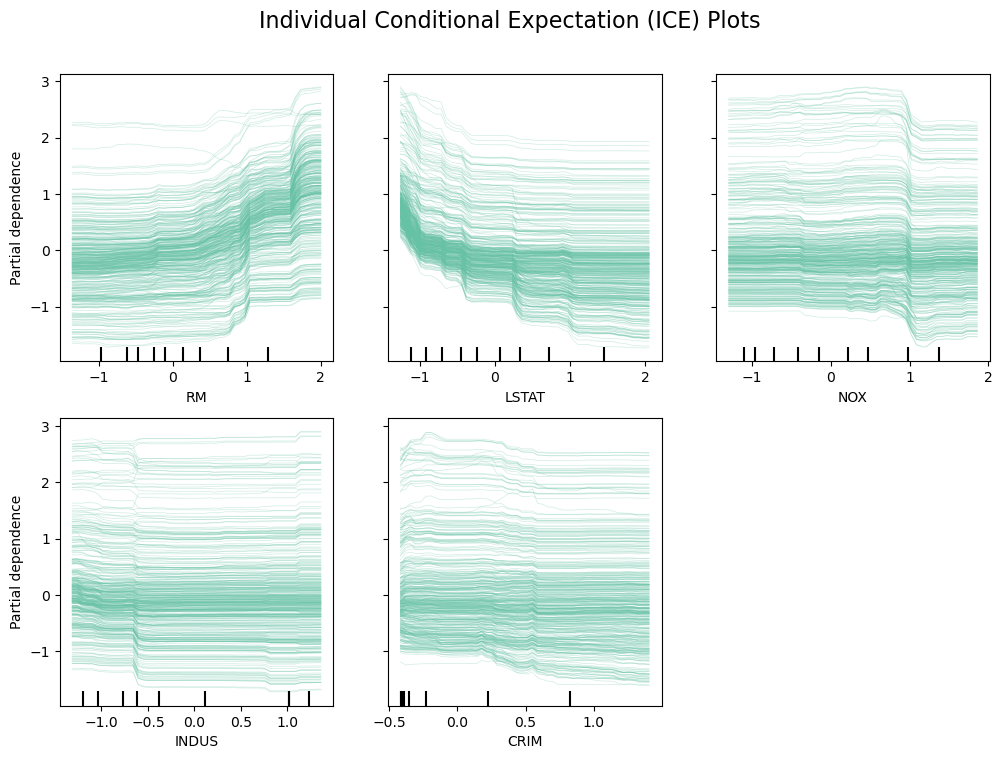

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

display = PartialDependenceDisplay.from_estimator(
    best_rf,
    X=X_train,
    features=top_features,
    kind="individual",  # Spécifier ICE
    grid_resolution=50,
    ax=ax
)

plt.suptitle("Individual Conditional Expectation (ICE) Plots", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

Ce graphique représente des *Individual Conditional Expectation (ICE) Plots*, qui détaillent l'impact des cinq variables les plus importantes sur la prédiction du modèle en traçant l'évolution individuelle de chaque observation. Contrairement aux *Partial Dependence Plots (PDP)*, qui montrent un effet moyen, les ICE permettent d'observer les variations spécifiques à chaque individu. On note que **RM (nombre de pièces) et LSTAT (statut socio-économique faible)** influencent fortement les prédictions, avec une tendance générale similaire aux PDP : RM a un effet positif et croissant, tandis que LSTAT a un effet négatif marqué. Cependant, les courbes individuelles révèlent des variations plus complexes, suggérant une hétérogénéité dans l'effet de ces variables selon les observations.  

D'autres variables comme **NOX (pollution), INDUS (zones industrielles) et CRIM (criminalité)** présentent des tendances plus nuancées. NOX montre une rupture autour d'une certaine valeur, indiquant que l'effet de la pollution sur la prédiction n'est pas linéaire. INDUS et CRIM ont des effets plus dispersés, avec certaines observations montrant un impact fort tandis que d'autres restent relativement insensibles à ces variables. En résumé, les ICE Plots permettent d’analyser les effets locaux et révèlent des interactions potentielles que les PDP pourraient masquer.

Ainsi, pour répondre à la question suivante "le PDP est-il une bonne représentation des variables importantes de votre modèle?", nous pouvons dire que bien que les PDP soient une bonne approximation globale des effets des variables importantes, ils ne suffisent pas toujours à capturer la complexité de ces effets, en particulier dans les modèles non linéaires ou interactifs. Les ICE complètent cette analyse en fournissant une représentation plus riche et précise des effets locaux, et ils sont particulièrement précis pour explorer les interactions potentielles et les comportements non linéaires. En somme, pour ce modèle, les ICE apportent des informations complémentaires cruciales par rapport aux PDP.

##### LIME

In [30]:
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode="regression"
)

#Sélection d'un individu pour l'explication
i = 77  # Exemple pour l'individu 77
sample = X_test.iloc[i].values
model_prediction = best_rf.predict(sample.reshape(1, -1))

#Explication locale
explanation = explainer.explain_instance(
    data_row=sample,
    predict_fn=best_rf.predict
)

#Affichage des résultats
explanation.show_in_notebook(show_table=True)

Ce graphique est une interprétation locale des prédictions d'un modèle utilisant **LIME (Local Interpretable Model-agnostic Explanations)**. LIME explique comment chaque variable a contribué à la prédiction pour une observation spécifique.  

Ici, la valeur prédite est **environ 2.29**, avec un impact différencié des variables explicatives. **Le nombre de pièces (RM > 0.50) est le facteur ayant l'effet le plus positif (+0.75), suivi de LSTAT (-0.82) qui contribue aussi positivement (+0.65)**. En revanche, des variables comme **INDUS (-0.88) et PTRATIO (-0.77) ont un impact plus faible mais toujours positif**. À l'opposé, certaines variables comme **NOX (-0.89), CRIM (-0.41) et AGE (-0.82)** ont une influence légèrement négative sur la prédiction.  

Le tableau de droite indique les valeurs des caractéristiques pour cette observation. On remarque que RM est élevé (2.23), ce qui explique son impact positif, tandis que LSTAT est relativement bas (-1.24), renforçant l'effet favorable sur la prédiction. Ce type d’explication est utile pour comprendre pourquoi un modèle prend une décision donnée et identifier les variables les plus influentes localement.

##### SHAP

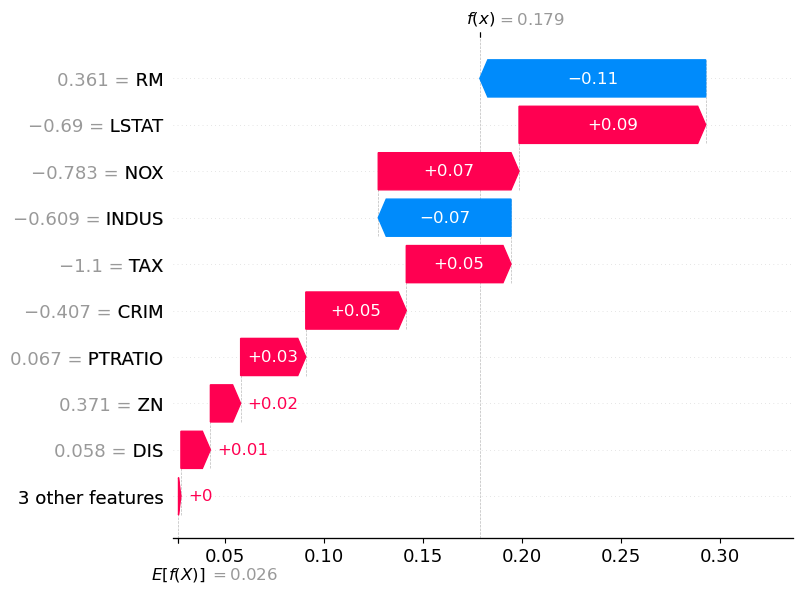

In [31]:
explainer = shap.TreeExplainer(best_rf)

#Calculer les SHAP values sur un échantillon pour réduire le temps de calcul
shap_values = explainer(X_train.iloc[0:100])

shap.initjs()

#Visualiser un Waterfall Plot pour un individu donné, par exemple le 77e individu
shap.waterfall_plot(shap_values[77])

Ce graphique représente une analyse SHAP (*SHapley Additive exPlanations*) sous la forme d'un *waterfall plot*, qui décompose la contribution des variables à une prédiction individuelle dans un modèle machine learning. La valeur de base (\( E[f(X)] = 0.026 \)) représente la moyenne des prédictions du modèle sur l'ensemble des données. Les variables influencent ensuite cette valeur initiale, en la faisant augmenter (rouge) ou diminuer (bleu), pour aboutir à la prédiction finale (\( f(x) = 0.179 \)).

Les variables les plus influentes ici sont **RM** (nombre moyen de pièces par logement), qui réduit significativement la prédiction (-0.11), et **LSTAT** (pourcentage de population à faible statut socio-économique), qui l'augmente fortement (+0.09). D'autres variables comme **NOX** (concentration en oxydes d'azote) et **TAX** (taux d'imposition) contribuent de manière plus modérée, tandis que des variables secondaires comme **PTRATIO**, **ZN** et **DIS** ont un impact mineur. Ce type de visualisation permet d'interpréter précisément les facteurs qui influencent une prédiction donnée, rendant le modèle plus transparent.

### 8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

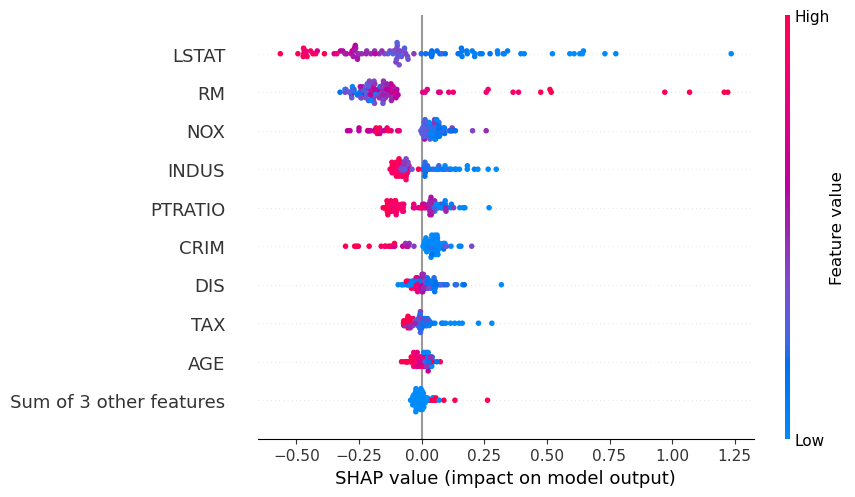

In [32]:
shap.plots.beeswarm(shap_values)

Ce graphique représente une *beeswarm plot* des valeurs SHAP, montrant l'impact de chaque variable sur les prédictions du modèle ainsi que leur relation avec les valeurs des caractéristiques. L'axe horizontal correspond aux valeurs SHAP, qui indiquent si une variable augmente ou diminue la prédiction, tandis que chaque point représente une observation individuelle.

Les variables sont classées par importance décroissante. Par exemple, **LSTAT** (pourcentage de population à faible statut socio-économique) a un impact significatif, avec des valeurs élevées (rouge) qui tendent à augmenter les prédictions, et des valeurs faibles (bleu) qui les réduisent. **RM** (nombre moyen de pièces par logement) suit une tendance inverse, où des valeurs élevées réduisent la prédiction. Les variables comme **NOX** (oxydes d'azote) et **INDUS** (proportion de terrain industriel) montrent également une forte dispersion des valeurs SHAP, indiquant leur influence notable sur les prédictions.

In [33]:
shap.force_plot(shap_values[77])

Le graphique ci dessus illustre l'importance des différentes variables explicatives dans notre modèle. Chaque variable contribue positivement ou négativement à la valeur prédite, comparée à une base moyenne (base value). Ici, la prédiction finale est de 0,18, influencée par des variables comme **NOX**, qui diminue fortement la prédiction de -0,7835 unités, ou encore **RM**, qui l'augmente de +0,361 unités. Les contributions des variables sont visualisées à l'aide de couleurs : le rouge indique une augmentation de la prédiction et le bleu une diminution.

Ce type d'analyse est essentiel pour comprendre le comportement du modèle et l'influence des variables explicatives. Ici, les variables négatives les plus influentes sont **NOX**, **LSTAT**, et **INDUS**, ce qui pourrait refléter des aspects défavorables. À l'inverse, des variables comme **RM** jouent un rôle positif en augmentant la prédiction, mettant en lumière leur lien significatif avec le phénomène modélisé.

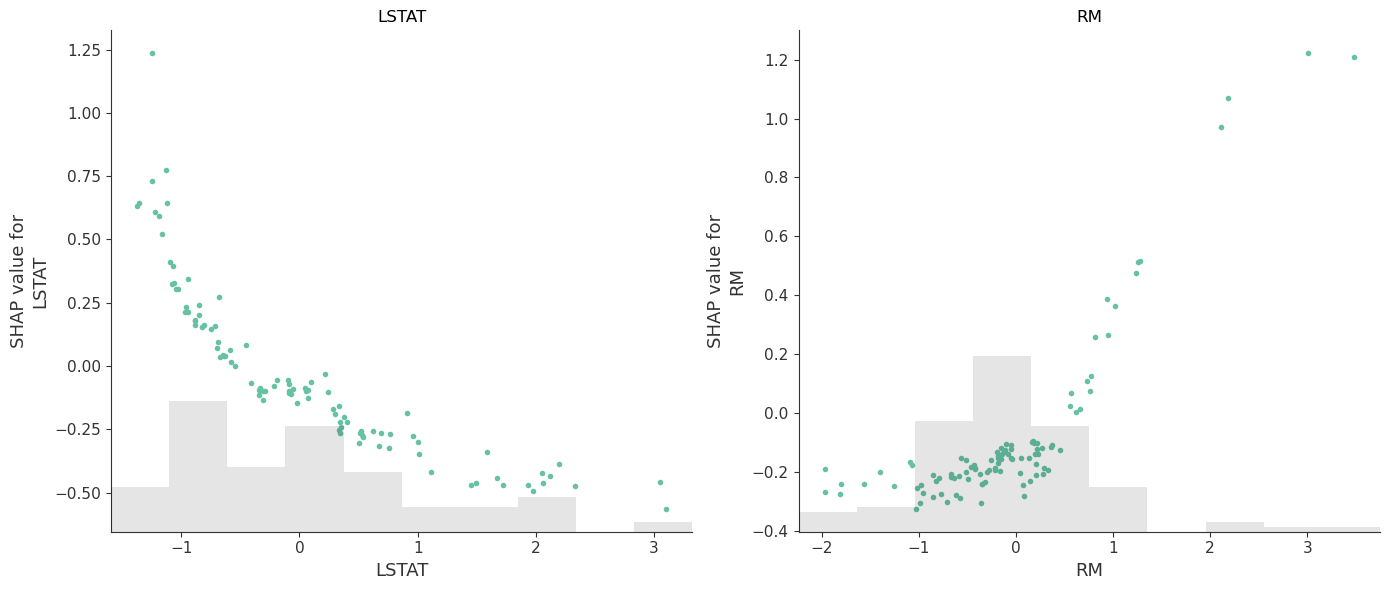

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#Graphique SHAP pour 'LSTAT'
shap.plots.scatter(shap_values[:, 'LSTAT'], show=False, ax=axes[0])
axes[0].collections[0].set_facecolor('#66c2a5')  #Applique la couleur verte
axes[0].set_title('LSTAT')

#Graphique SHAP pour 'RM'
shap.plots.scatter(shap_values[:, 'RM'], show=False, ax=axes[1])
axes[1].collections[0].set_facecolor('#66c2a5')  #Applique la couleur verte
axes[1].set_title('RM')

plt.tight_layout()
plt.show()

Les graphiques montrent l’effet des variables **LSTAT** (taux de population défavorisée) et **RM** (nombre moyen de pièces par logement) sur les prédictions du modèle à l’aide des valeurs SHAP. Pour **LSTAT**, on observe une relation décroissante : plus cette variable augmente, plus sa contribution à la prédiction est négative. Cela reflète un impact défavorable, typique dans des modèles liés à des indicateurs sociaux ou économiques, où un pourcentage élevé de population défavorisée tend à réduire des résultats tels que les prix de l’immobilier.

Pour **RM**, la relation est inverse : une augmentation du nombre moyen de pièces par logement a un effet positif sur les prédictions. Cela traduit un lien direct entre le standing des logements et les valeurs prédites. 

Les histogrammes en arrière-plan permettent de visualiser la distribution des valeurs des variables, ce qui aide à contextualiser leur influence.